## Twitter Dataset Prepare

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import tqdm
import regex
import os
import re
import shutil
import operator
import codecs
import time
import random
from math import log
from nltk import sent_tokenize
from pymystem3 import Mystem
from seaborn import heatmap
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc



from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

База данных состоит из 12 столбцов:
- id: уникальный номер сообщения в системе twitter;
- tdate: дата публикации сообщения (твита);
- tmane: имя пользователя, опубликовавшего сообщение;
- ttext:  текст сообщения (твита);
- ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
- trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
- trtf: число ретвитов
- tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
- tstcount: число всех сообщений пользователя в сети twitter;
- tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);
- tfrien: количество друзей пользователя (те люди, которых читает пользователь);
- listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

In [2]:
header = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtf', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']

#### Загружаем положительные и негативные твиты в один DataFrame, после этого перемешиваем с помощью sample(frac=1)

In [3]:
pos_twitts = pd.read_csv('train_positive.csv', sep=';', names=header)
neg_twitts = pd.read_csv('train_negative.csv', sep=';', names=header)
twitts = pd.concat([pos_twitts, neg_twitts], axis=0)
twitts = twitts.sample(frac=1)

#### Смотрим размерность нашего размеченного датасета и проверяем, что у нас 2 вида твитов(положительные(1) и негативные(-1))

In [4]:
print twitts.shape
twitts.head()

(226834, 12)


,id,tdate,tmane,ttext,ttype,trep,trtf,tfav,tstcount,tfol,tfrien,listcount
74736,410638392813039616,1386738796,RedMax77,"@nsafiullin щас попробую) если что, уж не руга...",1,0,0,0,22977,429,354,15
35278,413575344135110656,1387439020,98Sabinka,"Родичи елку поставили,наряжать будут снова без...",-1,0,0,0,4446,49,37,0
63738,416927860285112320,1388238322,Kelly_Basset,"единственная фотка где я пышечка, увиии\nМне н...",-1,0,0,0,188,32,35,1
104271,411119602673143808,1386853526,sutyvepiqi,"RT @volesixy: Я не кукла и не игрушка, я девоч...",1,0,3,0,332,177,152,0
33956,413288198388060162,1387370559,annyblackk,"скоро новый год, а я елку еще не купила(( над ...",-1,0,0,0,1384,296,478,1


In [5]:
twitts.ttype.unique()

array([ 1, -1])

## Working with Twitter texts

In [6]:
X = twitts.ttext.values
y = twitts.ttype.values

In [7]:
def prepare_text(text):
    text = text.lower().strip()
    text = re.sub(r'@\S+', '', text) # delete @user_name
    text = re.sub(r'#\W+', '', text) # delete #hashtag
    text = re.sub(r'[o_, O_, dd, dddd, ddd, 0-9, \:, \(, \), \!, \-, \;, \?, rt, \#]+', ' ', text) # delete smiles
    return text

In [8]:
X = [prepare_text(text).decode('utf-8') for text in X]

In [9]:
tokenizer = RegexpTokenizer('\w+|\S+')
r = RussianStemmer()

In [10]:
def tokenize(text):
    return tokenizer.tokenize(text)

def stem_text(text):
    return [r.stem(word) for word in text]

In [11]:
X = [tokenize(text) for text in X]

In [12]:
X = [stem_text(text) for text in X]

#### После стемминга мы получили в X набор слов вместо цельных предложений. Объединяем обратно из массива слов в предложения и после этого удаляем никнеймы, хештеги, указание ретвитов и смайлики

In [13]:
X_sent = [' '.join(words) for words in X]

In [14]:
X_sent_prepare = [prepare_text(text) for text in X_sent]

In [15]:
for x in X_sent_prepare[10:20]:
    print x

то чувств когд я сказа е тож сам с теб пятюн
мо русск сем я скуча по вам до скор встреч . сохран немн снег для мен и не дайт ем растая
оо даа ....тольк нич мне кажет не измен .. ну хот даниел и ли обща и на эт спс
мо проблем в том что я слишк быстр чита книг
захотел блин масленниц же испекл — а тепер их ест неохот
да уж збс погуля и конец особен пиздат был ахаа
у соседн дом машин спал фигов первоапрельск шутк ящета
так пиздострадан у нас с мах прост слез
я спокойн пом голов пот что не вер в примет тип голов нельз мыт перед экзамен эт придума лентя
я поня все одинок стесняшк поэт никак назван не будет . можн был так и написа мол "кошмар на улиц вяз "


In [16]:
print X_sent[0]

щас попроб есл что уж не руга вопрос задава буд


### Разбиваем наш датасет с помощью train test split и начинаем создавать модельки

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_sent_prepare, y, test_size=0.3, random_state=42)

#### Модель на Логистической регрессии дает лучший результат(0.746) с параметрами ngram_range=(1, 3), min_df=5. Вид модели роль не играет

In [18]:
model = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=5)), ('log_reg', LogisticRegression())])
model_tf_idf = Pipeline([('count', TfidfVectorizer(ngram_range=(1, 3), min_df=5)), ('log_reg', LogisticRegression())])

In [19]:
#X_train[:10]

In [20]:
#model = Pipeline([('count', CountVectorizer(ngram_range=(1, 1))), ('grad_boost', GradientBoostingClassifier())])
#model_tf_idf = Pipeline([('count', TfidfVectorizer(ngram_range=(1, 2), min_df=10)), ('grad_boost', GradientBoostingClassifier(max_depth=8, verbose=True, n_estimators=50))])

In [21]:
#gauss = GaussianNB()
#gauss.fit([item.split(' ') for item in X_train], y_train)

In [22]:
#model = Pipeline([('count', CountVectorizer(ngram_range=(1, 2))), ('gauss_NB', GaussianNB())])
#model_tf_idf = Pipeline([('count', TfidfVectorizer(ngram_range=(1, 2), min_df=10)), ('gauss_NB', GaussianNB())])

In [23]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        s...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [24]:
model_tf_idf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('count', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=Tru...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

## Смотрим у каких слов получились самые влиятельные веса и считаем оценки

In [25]:
words = model.steps[0][1].get_feature_names()
coefs = model.steps[1][1].coef_[0]

In [26]:
model_coefs = pd.Series(index=words, data=coefs)

In [27]:
model_coefs.sort_values()

обидн            -2.972192
пичал            -2.827795
печальн          -2.605764
не приятн        -2.589569
сочувств         -2.402953
соболезнован     -2.399653
расстро          -2.396655
сожален          -2.305794
не добр          -2.305379
картинк надпис   -2.300218
не понрав        -2.296496
погибш           -2.255798
печальк          -2.210055
пичальк          -2.177849
грустн           -2.170208
распа            -2.150982
собира завтр     -2.150547
ув               -2.149349
заболет          -2.129747
печал            -2.109306
рев              -2.096820
скорб            -2.091153
настроен нет     -2.085688
погибл           -2.083316
греба            -2.054821
испорт           -2.050987
теракт           -2.049528
жалк             -2.030805
ебуч             -2.029949
шерлок           -2.022629
                    ...   
смех              1.880485
конкурент         1.905985
хочет больш       1.920711
не сомнева        1.921269
не захож          1.930715
не холодн         1.941302
а

In [28]:
preds = model.predict(X_test)

In [29]:
preds_tf_idf = model_tf_idf.predict(X_test)

In [30]:
accuracy_score(preds, y_test)

0.74117940956047668

In [31]:
accuracy_score(preds_tf_idf, y_test)

0.74999632628469826

In [32]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds_tf_idf)
roc_auc = auc(false_positive_rate, true_positive_rate)

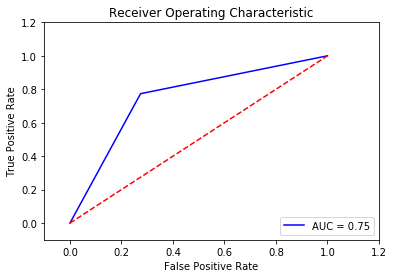

In [33]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

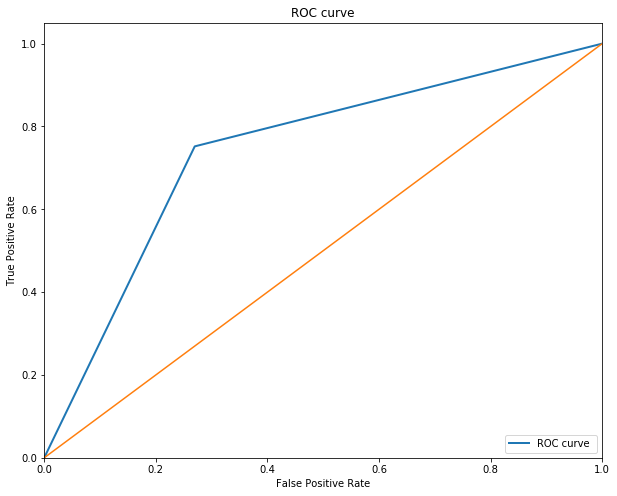

In [34]:
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
#plt.savefig("ROC.png")
plt.show()

## Load Twitts from dump

In [8]:
import json
import pandas as pd

In [5]:
DUMP_PATH_APPLE = 'TwitterSearchScrapper/dump/APPLE/apple_2017-09-01_2017-11-20'
DUMP_PATH_SECHIN = 'TwitterSearchScrapper/dump/СЕЧИН/Сечин_2017-01-01_2017-11-20'
DUMP_PATH_ROSN = 'TwitterSearchScrapper/dump/РОСНЕФТЬ/Роснефть_2017-09-01_2017-11-20'
DUMP_PATH_IPHONE = 'TwitterSearchScrapper/dump/IPHONE/iphone_2017-09-01_2017-11-20'
DUMP_PATH_MAIL = 'TwitterSearchScrapper/dump/MAIL.RU/Mail.ru_2017-09-01_2017-11-20'

In [6]:
data_apple = pd.read_json(DUMP_PATH_APPLE)
data_sechin = pd.read_json(DUMP_PATH_SECHIN)
data_rosn = pd.read_json(DUMP_PATH_ROSN)
data_iphone = pd.read_json(DUMP_PATH_IPHONE)
data_mail = pd.read_json(DUMP_PATH_MAIL)

In [7]:
total_test_data = pd.concat([data_apple, data_iphone, data_mail, data_rosn, data_sechin], axis=0)

In [9]:
total_test_data.shape

(56243, 18)

In [10]:
total_test_data.head()

,attach,favorites,id,link,mentions,quote,quote_id,replies,reply,reply_id,retweet,retweet_id,retweets,text,timestamp,user_id,user_name,user_username
0,False,0,903739658512846848,https://twitter.com/Jalilov1Alisher/status/903...,[],False,0,0,False,903739658512846848,False,0,0,Восстановление токопроводящих дорожек iPhone6 ...,2017-09-01 22:01:39,2393277684,Алишер,Jalilov1Alisher
1,False,0,903706496701272064,https://twitter.com/bobaleh/status/90370649670...,[],False,0,0,False,903706496701272064,False,0,0,Это что еще за? #apple #iphone pic.twitter.com...,2017-09-01 19:49:53,107208664,Илья Егоров,bobaleh
2,False,0,903705849574633472,https://twitter.com/carrot_23/status/903705849...,[],False,0,0,False,903705849574633472,False,0,0,Берёшь в руки 5 iPhone после 7ки и он такой не...,2017-09-01 19:47:19,465395891,Ksana Carrot,carrot_23
3,True,0,903704868346626048,https://twitter.com/rozumno/status/90370486834...,[],False,0,0,False,903704868346626048,False,0,0,#Apple претендует на 50% рынка «умных» часов б...,2017-09-01 19:43:25,2225566922,Веб-студия Rozum.no,rozumno
4,False,1,903703648605175808,https://twitter.com/iskovskih/status/903703648...,[],False,0,0,False,903703648605175808,False,0,0,12 сентября презентация #apple и буквально пар...,2017-09-01 19:38:34,390055117,Mike Iskovskih,iskovskih


In [11]:
total_test_data.to_csv('test_data.csv', sep=';')